In [ ]:
import sys
import subprocess

def install_if_missing(package):
    try:
        __import__(package.split('-')[0].split('[')[0])
    except ImportError:
        print(f"Instalando {package}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", "--quiet", package])

dependencies = [
    'pandas', 'numpy', 'matplotlib', 'seaborn', 'plotly',
    'psycopg2-binary'
]

for dep in dependencies:
    install_if_missing(dep)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from datetime import datetime
import psycopg2
import warnings
warnings.filterwarnings('ignore')

# Configuração de visualização
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

print("Bibliotecas importadas com sucesso!")


Instalando plotly...
✅ Bibliotecas importadas com sucesso!


## 2. Conexão e Carregamento de Dados


In [ ]:
# Configurações de conexão
DB_CONFIG = {
    'host': 'postgres',
    'port': 5432,
    'database': 'inmet_db',
    'user': 'inmet_user',
    'password': 'inmet_password'
}

# Query para carregar dados com classificação de intensidade
query = """
SELECT 
    dm.timestamp_utc,
    dm.codigo_wmo,
    e.nome as nome_estacao,
    e.uf,
    dm.precipitacao_mm,
    dm.intensidade_chuva,
    dm.pressao_estacao_mb,
    dm.umidade_rel_horaria_pct,
    dm.vento_velocidade_ms,
    dm.temperatura_ar_c
FROM dados_meteorologicos dm
JOIN estacoes e ON dm.codigo_wmo = e.codigo_wmo
WHERE dm.intensidade_chuva IS NOT NULL
ORDER BY dm.timestamp_utc
"""

# Lê dados usando conexão direta com psycopg2 (evita problemas de encoding)
try:
    conn = psycopg2.connect(
        host=DB_CONFIG['host'],
        port=DB_CONFIG['port'],
        database=DB_CONFIG['database'],
        user=DB_CONFIG['user'],
        password=DB_CONFIG['password']
    )
    conn.set_client_encoding('UTF8')
    df = pd.read_sql(query, conn)
    conn.close()
    
    # Converte timestamp
    df['timestamp_utc'] = pd.to_datetime(df['timestamp_utc'])
    
    print(f"Dados carregados: {len(df):,} registros")
    print(f"Período: {df['timestamp_utc'].min()} até {df['timestamp_utc'].max()}")
    print(f"Estações: {df['codigo_wmo'].nunique()}")
    
except Exception as e:
    print(f"Erro ao carregar dados: {e}")
    df = pd.DataFrame()

if len(df) > 0:
    print(f"\nDistribuição de classes:")
    display(df['intensidade_chuva'].value_counts())
    display(df.head())
else:
    print("Nenhum dado disponível para visualização!")


✅ Dados carregados: 96,480 registros
Período: 2024-01-01 00:00:00 até 2025-10-31 23:00:00
Estações: 6

Distribuição de classes:


intensidade_chuva
sem_chuva    93133
leve          2855
moderada       428
forte           64
Name: count, dtype: int64

,timestamp_utc,codigo_wmo,nome_estacao,uf,precipitacao_mm,intensidade_chuva,pressao_estacao_mb,umidade_rel_horaria_pct,vento_velocidade_ms,temperatura_ar_c
0,2024-01-01,A366,OURICURI,PE,0.0,sem_chuva,960.8,68.0,1.9,26.4
1,2024-01-01,A357,PALMARES,PE,0.0,sem_chuva,993.9,86.0,1.2,25.5
2,2024-01-01,A322,GARANHUNS,PE,NaN,sem_chuva,922.1,NaN,3.5,22.2
3,2024-01-01,A350,SERRA TALHADA,PE,0.8,leve,956.2,86.0,1.1,22.7
4,2024-01-01,A328,SURUBIM,PE,NaN,sem_chuva,NaN,NaN,NaN,NaN


## 3. Gráfico de Barras por Classe de Intensidade (Problema 7.8)



✅ Gráfico salvo em: /home/jovyan/work/grafico_barras_intensidade_chuva.png


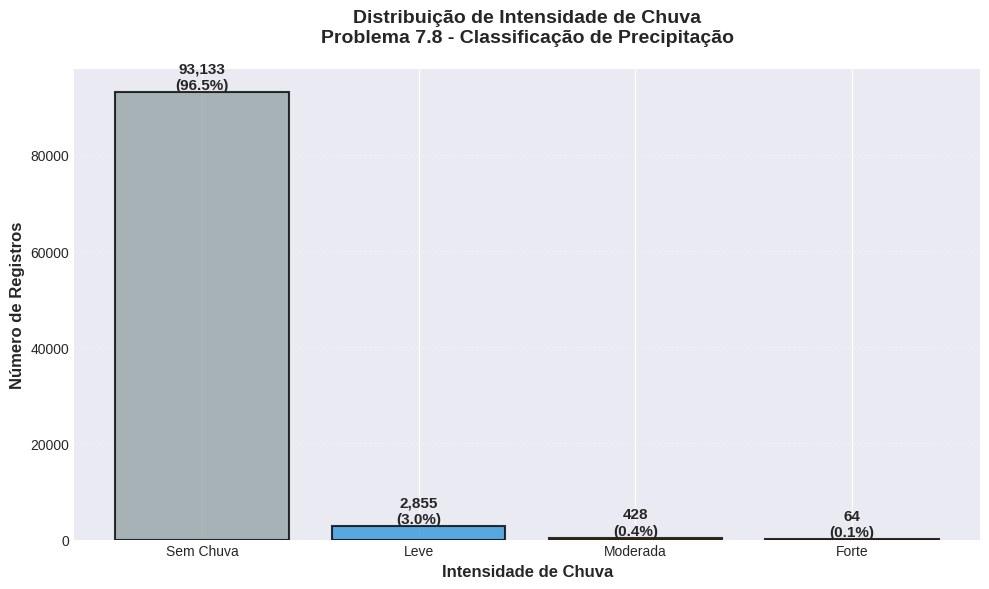


ESTATÍSTICAS POR CLASSE
Sem Chuva      :   93,133 registros (96.53%)
Leve           :    2,855 registros ( 2.96%)
Moderada       :      428 registros ( 0.44%)
Forte          :       64 registros ( 0.07%)


In [ ]:
if len(df) > 0:
    # Conta registros por classe
    contagem_classes = df['intensidade_chuva'].value_counts().sort_index()
    
    # Mapeia nomes para português
    nomes_classes = {
        'sem_chuva': 'Sem Chuva',
        'leve': 'Leve',
        'moderada': 'Moderada',
        'forte': 'Forte'
    }
    
    # Cores para cada classe
    cores = {
        'sem_chuva': '#95a5a6',  # Cinza
        'leve': '#3498db',       # Azul claro
        'moderada': '#f39c12',   # Laranja
        'forte': '#e74c3c'       # Vermelho
    }
    
    # Prepara dados para o gráfico
    classes_ordenadas = ['sem_chuva', 'leve', 'moderada', 'forte']
    valores = [contagem_classes.get(classe, 0) for classe in classes_ordenadas]
    labels = [nomes_classes[classe] for classe in classes_ordenadas]
    cores_barras = [cores[classe] for classe in classes_ordenadas]
    
    # Cria gráfico de barras
    fig, ax = plt.subplots(figsize=(10, 6))
    
    bars = ax.bar(labels, valores, color=cores_barras, alpha=0.8, edgecolor='black', linewidth=1.5)
    
    # Adiciona valores nas barras
    for bar, valor in zip(bars, valores):
        altura = bar.get_height()
        percentual = (valor / len(df)) * 100
        ax.text(bar.get_x() + bar.get_width()/2., altura,
                f'{valor:,}\n({percentual:.1f}%)',
                ha='center', va='bottom', fontsize=11, fontweight='bold')
    
    # Customiza o gráfico
    ax.set_xlabel('Intensidade de Chuva', fontsize=12, fontweight='bold')
    ax.set_ylabel('Número de Registros', fontsize=12, fontweight='bold')
    ax.set_title('Distribuição de Intensidade de Chuva\nProblema 7.8 - Classificação de Precipitação', 
                 fontsize=14, fontweight='bold', pad=20)
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    
    plt.tight_layout()
    
    # Salva o gráfico
    output_path = '/home/jovyan/work/grafico_barras_intensidade_chuva.png'
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    print(f"\nGráfico salvo em: {output_path}")
    
    plt.show()
    
    # Estatísticas
    print("\n" + "="*60)
    print("ESTATÍSTICAS POR CLASSE")
    print("="*60)
    for classe, valor in zip(labels, valores):
        percentual = (valor / len(df)) * 100
        print(f"{classe:15s}: {valor:>8,} registros ({percentual:>5.2f}%)")
else:
    print("Nenhum dado disponível para visualização!")



✅ Gráfico salvo em: /home/jovyan/work/linha_temporal_intensidade_chuva.png


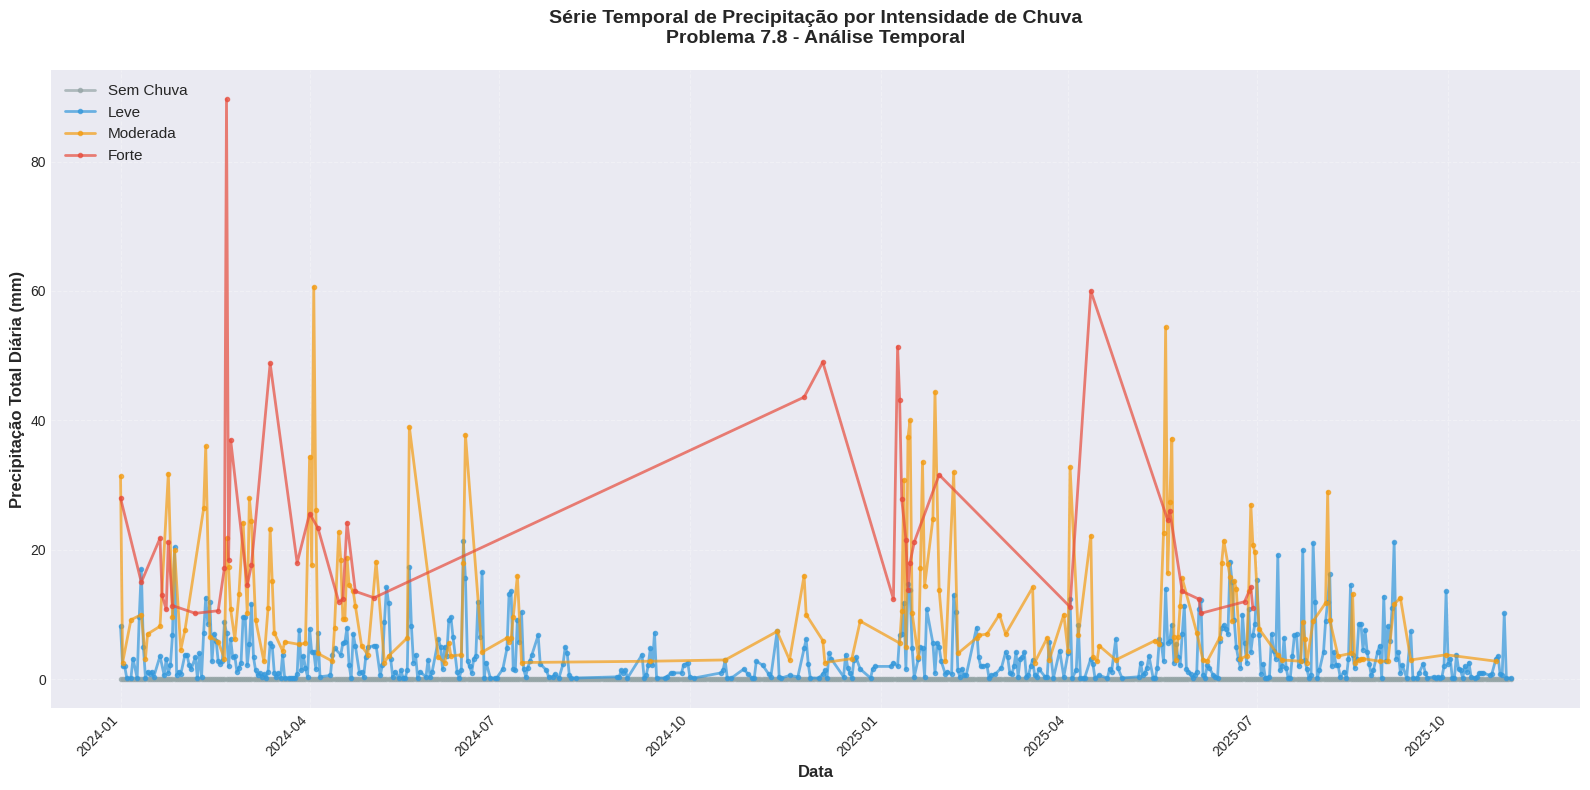

In [ ]:
if len(df) > 0:
    # Agrupa por data e classe para criar série temporal
    df['data'] = df['timestamp_utc'].dt.date
    
    # Agrega dados diários por classe
    df_temporal = df.groupby(['data', 'intensidade_chuva']).agg({
        'precipitacao_mm': 'sum',
        'codigo_wmo': 'count'
    }).reset_index()
    df_temporal.columns = ['data', 'intensidade_chuva', 'precipitacao_total', 'num_registros']
    df_temporal['data'] = pd.to_datetime(df_temporal['data'])
    
    # Cores para cada classe
    cores_temporal = {
        'sem_chuva': '#95a5a6',  # Cinza
        'leve': '#3498db',       # Azul claro
        'moderada': '#f39c12',   # Laranja
        'forte': '#e74c3c'      # Vermelho
    }
    
    nomes_classes = {
        'sem_chuva': 'Sem Chuva',
        'leve': 'Leve',
        'moderada': 'Moderada',
        'forte': 'Forte'
    }
    
    # Cria figura
    fig, ax = plt.subplots(figsize=(16, 8))
    
    # Plota linha para cada classe
    classes_ordenadas = ['sem_chuva', 'leve', 'moderada', 'forte']
    
    for classe in classes_ordenadas:
        df_classe = df_temporal[df_temporal['intensidade_chuva'] == classe].sort_values('data')
        if len(df_classe) > 0:
            ax.plot(df_classe['data'], df_classe['precipitacao_total'], 
                   label=nomes_classes[classe], 
                   color=cores_temporal[classe], 
                   linewidth=2, 
                   alpha=0.7,
                   marker='o',
                   markersize=3)
    
    # Customiza o gráfico
    ax.set_xlabel('Data', fontsize=12, fontweight='bold')
    ax.set_ylabel('Precipitação Total Diária (mm)', fontsize=12, fontweight='bold')
    ax.set_title('Série Temporal de Precipitação por Intensidade de Chuva\nProblema 7.8 - Análise Temporal', 
                 fontsize=14, fontweight='bold', pad=20)
    ax.legend(loc='upper left', fontsize=11, framealpha=0.9)
    ax.grid(True, alpha=0.3, linestyle='--')
    
    # Formata eixo x
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    
    # Salva o gráfico
    output_path = '/home/jovyan/work/linha_temporal_intensidade_chuva.png'
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    print(f"\nGráfico salvo em: {output_path}")
    
    plt.show()
    
else:
    print("Nenhum dado disponível para visualização!")


## 5. Análise por Estação


✅ Gráfico salvo em: /home/jovyan/work/grafico_estacoes_intensidade.png


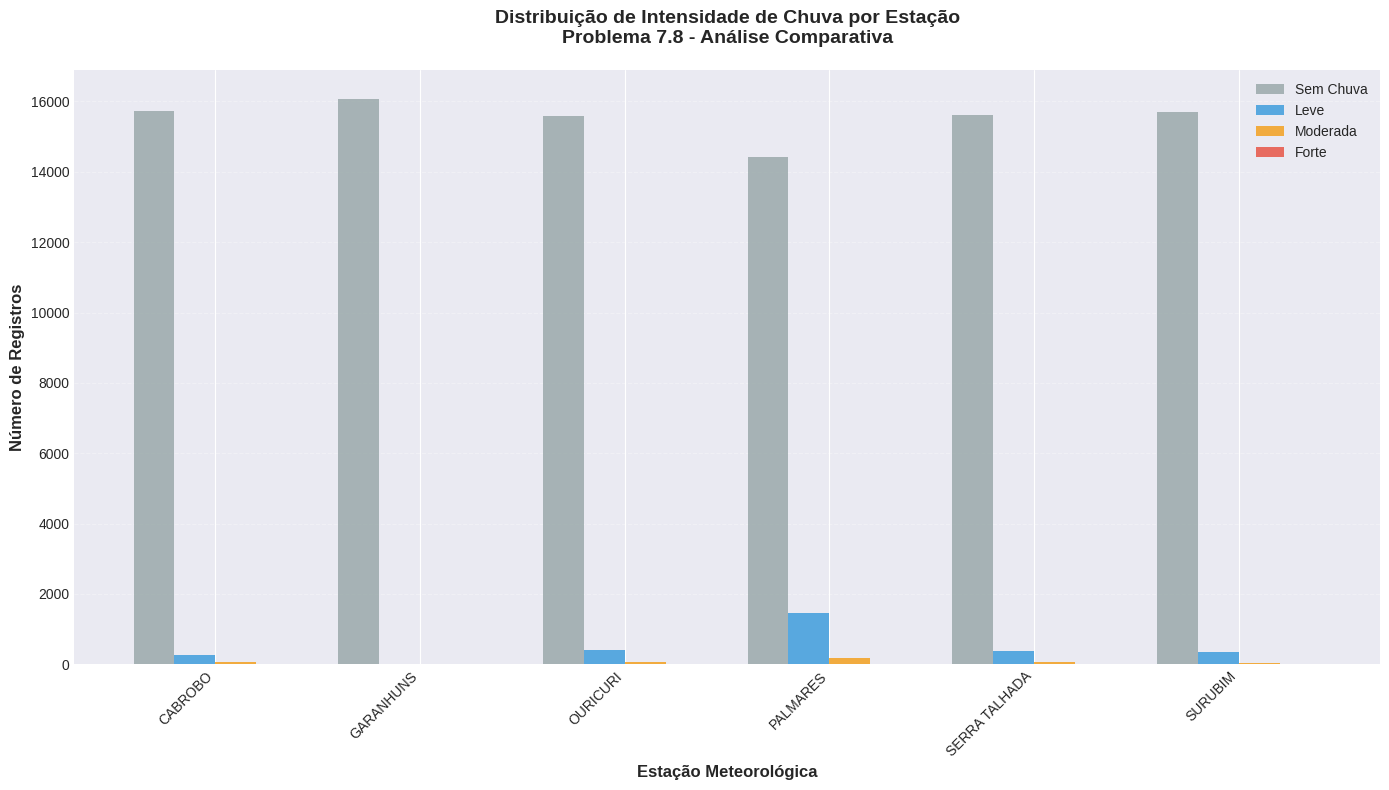

In [ ]:
if len(df) > 0:
    # Análise de distribuição por estação
    df_estacao = df.groupby(['nome_estacao', 'intensidade_chuva']).size().reset_index(name='count')
    df_estacao_pivot = df_estacao.pivot(index='nome_estacao', columns='intensidade_chuva', values='count').fillna(0)
    
    # Ordena classes
    classes_ordenadas = ['sem_chuva', 'leve', 'moderada', 'forte']
    df_estacao_pivot = df_estacao_pivot.reindex(columns=classes_ordenadas, fill_value=0)
    
    # Cria gráfico de barras agrupadas
    fig, ax = plt.subplots(figsize=(14, 8))
    
    x = np.arange(len(df_estacao_pivot.index))
    width = 0.2
    
    cores = {
        'sem_chuva': '#95a5a6',
        'leve': '#3498db',
        'moderada': '#f39c12',
        'forte': '#e74c3c'
    }
    
    nomes_classes = {
        'sem_chuva': 'Sem Chuva',
        'leve': 'Leve',
        'moderada': 'Moderada',
        'forte': 'Forte'
    }
    
    for i, classe in enumerate(classes_ordenadas):
        offset = (i - 1.5) * width
        if classe in df_estacao_pivot.columns:
            ax.bar(x + offset, df_estacao_pivot[classe], width, 
                   label=nomes_classes[classe], color=cores[classe], alpha=0.8)
    
    ax.set_xlabel('Estação Meteorológica', fontsize=12, fontweight='bold')
    ax.set_ylabel('Número de Registros', fontsize=12, fontweight='bold')
    ax.set_title('Distribuição de Intensidade de Chuva por Estação\nProblema 7.8 - Análise Comparativa', 
                 fontsize=14, fontweight='bold', pad=20)
    ax.set_xticks(x)
    ax.set_xticklabels(df_estacao_pivot.index, rotation=45, ha='right')
    ax.legend()
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    
    plt.tight_layout()
    
    output_path = '/home/jovyan/work/grafico_estacoes_intensidade.png'
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    print(f"Gráfico salvo em: {output_path}")
    
    plt.show()
else:
    print("Nenhum dado disponível para visualização!")


## 6. Mapa de Calor - Correlação entre Variáveis


✅ Gráfico salvo em: /home/jovyan/work/mapa_calor_correlacao.png


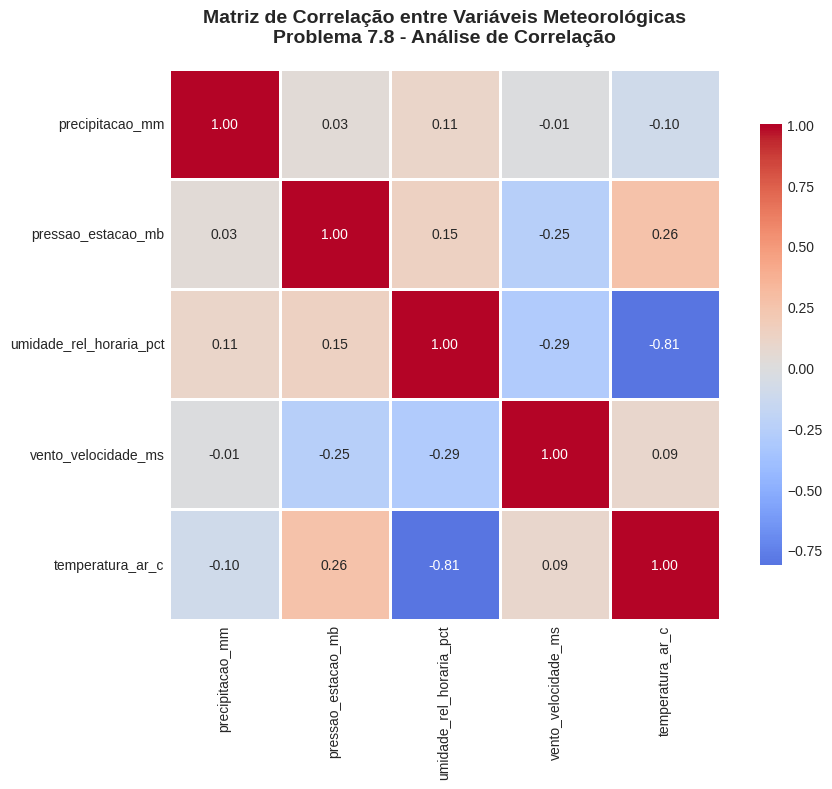

In [ ]:
if len(df) > 0:
    # Seleciona variáveis numéricas para correlação
    vars_numericas = ['precipitacao_mm', 'pressao_estacao_mb', 
                      'umidade_rel_horaria_pct', 'vento_velocidade_ms', 
                      'temperatura_ar_c']
    
    vars_existentes = [v for v in vars_numericas if v in df.columns]
    
    if vars_existentes:
        # Calcula matriz de correlação
        df_corr = df[vars_existentes].corr()
        
        # Cria mapa de calor
        fig, ax = plt.subplots(figsize=(10, 8))
        
        sns.heatmap(df_corr, annot=True, fmt='.2f', cmap='coolwarm', 
                    center=0, square=True, linewidths=1, 
                    cbar_kws={"shrink": 0.8}, ax=ax)
        
        ax.set_title('Matriz de Correlação entre Variáveis Meteorológicas\nProblema 7.8 - Análise de Correlação', 
                     fontsize=14, fontweight='bold', pad=20)
        
        plt.tight_layout()
        
        output_path = '/home/jovyan/work/mapa_calor_correlacao.png'
        plt.savefig(output_path, dpi=300, bbox_inches='tight')
        print(f"Gráfico salvo em: {output_path}")
        
        plt.show()
    else:
        print("Variáveis numéricas não encontradas!")
else:
    print("Nenhum dado disponível para visualização!")


## 7. Resumo das Visualizações


In [ ]:
print("="*80)
print("RESUMO DAS VISUALIZAÇÕES GERADAS")
print("="*80)
print("\nGráficos criados (Problema 7.8):")
print("  1. Gráfico de Barras por Classe de Intensidade")
print("  2. Linha Temporal Colorida por Categoria")
print("  3. Análise por Estação (Barras Agrupadas)")
print("  4. Mapa de Calor - Correlação entre Variáveis")
print("\nArquivos salvos em: /home/jovyan/work/")
print("  - grafico_barras_intensidade_chuva.png")
print("  - linha_temporal_intensidade_chuva.png")
print("  - grafico_estacoes_intensidade.png")
print("  - mapa_calor_correlacao.png")
print("\nPróximos passos:")
print("  1. Use os gráficos PNG no relatório técnico")
print("  2. Configure dashboards no Trendz Analytics (http://localhost:8888)")
print("  3. Complete o relatório técnico em PDF")
print("\n" + "="*80)


RESUMO DAS VISUALIZAÇÕES GERADAS

✅ Gráficos criados (Problema 7.8):
  1. Gráfico de Barras por Classe de Intensidade
  2. Linha Temporal Colorida por Categoria
  3. Análise por Estação (Barras Agrupadas)
  4. Mapa de Calor - Correlação entre Variáveis

📁 Arquivos salvos em: /home/jovyan/work/
  - grafico_barras_intensidade_chuva.png
  - linha_temporal_intensidade_chuva.png
  - grafico_estacoes_intensidade.png
  - mapa_calor_correlacao.png

📊 Próximos passos:
  1. Use os gráficos PNG no relatório técnico
  2. Configure dashboards no Trendz Analytics (http://localhost:8888)
  3. Complete o relatório técnico em PDF

